## Extractor MongoDB a .JSON

#### Import Libraries

In [ ]:
from sshtunnel import SSHTunnelForwarder
import pymongo
import pprint
import json
from bson import json_util
import time
import threading

#### Extractor 

In [ ]:
# Print time before before extract data
time1 = time.asctime()
print(time1)

# Credentials of MongoDB Prod
MONGO_HOST = "50.19.38.200"
MONGO_USER = "ubuntu"
MONGO_PASS = "PASSWORD"
PEM = "D:/Topic Flower/db"
MONGO_DB = "topicflower_prod"
MONGO_COLLECTION = "post"

# Define local path
path = r'C:\Users\Darwoft\Desktop\Document Classification\topics\\'


def extraer_coleccion(cole):
    collection = db[cole]

    # NoSql query to MongoDB to extract the first 100.000 post
    cursor = collection.find({"$and": [{'topic': {"$ne": None}}, {"$or": [{'twitter': {"$ne": None}}, {'data_facebook': {"$ne": None}}]}]}, {
                             "brandname": 1, "topic": 1, "topicname": 1, "twitter.posttext": 1, "data_facebook.message": 1}).limit(100000)
    texto = '['
    for fut in cursor:
        texto = texto + json.dumps(fut,  default=json_util.default) + ','
    texto = texto[:-1]
    texto = texto + ']'
    archivo_post = path + str(cole)+'.json'

    # Save the query data into a .json file
    with open(archivo_post, 'w', encoding='UTF-8') as file:
        file.write(texto)
    return None


# Define SSH Tunnel
server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=PEM,
    remote_bind_address=('127.0.0.1', 27017)
)

# Start SSH tunnel
server.start()

# Server.local_bind_port is assigned local port
client = pymongo.MongoClient(
    '127.0.0.1', server.local_bind_port, maxPoolSize=50, waitQueueMultiple=10)
db = client[MONGO_DB]

# call Function to extract Post collection data
extraer_coleccion('post')

# Close connection
client.close()
server.stop()
time2 = time.asctime()

# Print time for the whole process
print(time2)

## Convert .Json to CSV file

In [ ]:
"""
Before convert the .json to CSV file we need to find and replace the "data_facebook":¨{}
because to make it work we need to replace it for "data_facebook": {"message": ""}
If not we will have a error before convert to CSV file
This will be update in the future 
"""

#### Import Libraries

In [ ]:
import pandas as pd
import json
import re
#asd

#### Convertor

In [ ]:
# Define Json and CSV files
archivo_post = r'C:\Users\Darwoft\Desktop\Document Classification\topics\post.json'
archivo_sent = r'C:\Users\Darwoft\Desktop\Document Classification\topics\Topics-text.csv'

# Open Json file
with open(archivo_post, 'r', encoding='UTF-8') as file:
    data = json.load(file)


facebooktext = ''
twittertext = ''

# Define CSV columns
texto = "id,brandname,topic,topicname,twittertext,facebooktext" + '\n'

for f in data:
    try:
        ID = f.get('_id').get('$oid')
        brandname = f.get('brandname')
        topic = f.get('topic')
        topic = topic.lower()
        topicname = f.get('topicname')
        twittertext = f.get('twitter').get('posttext')

        # Delete special characters, URL and Tags from the post
        twittertext = twittertext.replace(',', '')
        twittertext = twittertext.replace('\n', '')
        twittertext = twittertext.replace('\"', '')
        twittertext = twittertext.replace('"', '')
        twittertext = re.sub(r"http\S+", '', twittertext)
        twittertext = re.sub(r"@\S+", '', twittertext)
    except:
        facebooktext = f.get('data_facebook').get('message')

        # Delete special characters, URL and Tags from the post
        facebooktext = facebooktext.replace(',', '')
        facebooktext = facebooktext.replace('\n', '')
        facebooktext = facebooktext.replace('\"', '')
        facebooktext = facebooktext.replace('"', '')
        facebooktext = re.sub(r"http\S+", '', facebooktext)
        facebooktext = re.sub(r"@\S+", '', facebooktext)

    # Create CSV estruture separate by ","
    texto = texto + str(ID) + "," + str(brandname) + "," + str(topic) + "," + \
        str(topicname) + "," + str(twittertext) + "," + str(facebooktext)+'\n'
    facebooktext = ''
    twittertext = ''

# Open and write in the CSV File
with open(archivo_sent, 'w', encoding='UTF-8') as file:
    file.write(texto)

## Limpieza y Analisis Dataset

#### Import Libraries

In [1]:
import pandas as pd

#### Limpieza Dataset

In [3]:
# Import CSV File and combine Twitter post with Faceoobk Post text
data = pd.read_csv(
    r'C:\Users\Darwoft\Desktop\Post Classication\topics\Topics-text.csv')
Post = data.twittertext.fillna(data.facebooktext)

C:\Users\Darwoft\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Tamaño Data, 100075 filas
data.shape

(100075, 12)

In [5]:
# show the top 15 of topics
data['topic'].unique()
data.topic.value_counts().head(15)

contenido              4912
productos              4013
eventos                3563
resultados             2242
ofertas                1830
noticias               1429
promociones            1368
cloud                  1180
product                1142
politica               1081
bigdataandanalytics    1074
thought leadership     1029
sucursales              958
sociedad                926
interaction             852
Name: topic, dtype: int64

In [7]:
# Convert CSV to Dataframe with Topic and Post Columns
df = pd.DataFrame()
df['Topic'] = data['topic']
df['Post'] = Post

In [8]:
# Count null values
df.isnull().sum()

Topic       75
Post     13303
dtype: int64

In [9]:
# Drop that null values
df_sin_nan = df.dropna(how='any')
df_sin_nan.isnull().sum()

Topic    0
Post     0
dtype: int64

In [10]:
df_sin_nan.head(10)

,Topic,Post
0,andinosport,Luz verde para la campaña 2015: Cristina anunc...
1,andino sport,Boca visita a Estudiantes necesitado de ganar ...
2,mucho show,Se filtran más fotos prohibidas de famosas
3,tecno,La tercera edición del Media Party Buenos Aire...
4,sucursales,Hoy en SAMBIL Santo Domingo y GALERIA 360 labo...
5,sucursales,Estamos laborando en GALERIA 360 de 9:00 a.m. ...
6,economía,El 15% de los argentinos hace compras on line
7,economa,Verallia lanza una nueva botella y la apertura...
8,cloud,Gracias a #Softlayer expandimos aún más nuestr...
9,mobile,Cuatro letras para ayudar a tu negocio a crece...


In [11]:
# Select 7 top topics to train the model
df_modelo = df_sin_nan[df_sin_nan.Topic.isin(
    ['contenido', 'productos', 'eventos', 'resultados', 'ofertas', 'noticias', 'promociones'])]
df_modelo['Topic'].unique()
df_modelo.Topic.value_counts()

contenido      4548
productos      3511
eventos        3402
resultados     2242
ofertas        1782
noticias       1395
promociones    1145
Name: Topic, dtype: int64

In [12]:
# Factorize the categorizal Data
df_modelo['Topic_ID'] = df_modelo['Topic'].factorize()[0]
df_modelo.head(10)

C:\Users\Darwoft\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Topic,Post,Topic_ID
45,productos,llsjdlsjdlsjdlsjdlskljdjaldasdllllllllllllllll...,0
47,contenido,El #veranoclaro se hizo pa' goza. ¡Disfruta rí...,1
49,productos,Consulta tus productos a través de Internet Ba...,0
50,productos,Hacer tu compra navideña te sale mejor con tu ...,0
51,productos,Usa tu Tarjeta Mujer #BHDLeon en salones de be...,0
63,eventos,Hay momentos se disfrutan mejor con una buena ...,2
64,eventos,¡Nuestra gerente de compras de decoración hoga...,2
65,eventos,¡Participa para ganar una lluvia de bonos de R...,2
66,eventos,¡Disfruta de éste gran espectáculo y llévate u...,2
67,eventos,¡El Coro Armonía vino a ponernos a bailar en e...,2


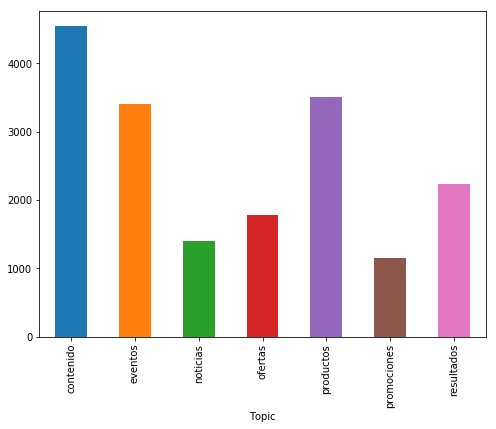

In [14]:
# Graph the amount of post of each topic
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
df_modelo.groupby('Topic').Post.count().plot.bar(ylim=0)
plt.show()

## Entrenamiento Modelo ML Lineal SVC

#### Import libraries

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import itertools
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#### Train Model and Statistics

In [16]:
#Split dataframe into 80% train 20 % test
X_train, X_test, y_train, y_test = train_test_split(
    df_modelo.Post, df_modelo.Topic, test_size=0.20, stratify=df_modelo.Topic, random_state=12)

In [17]:
#Declare the stopwords to take out before training the model
nltk.download('punkt')
nltk.download('stopwords')
stops = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darwoft\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darwoft\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#Vectorize the corpus of data 
vectorizer = TfidfVectorizer(
    analyzer='word', tokenizer=nltk.word_tokenize, stop_words=stops)
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

In [19]:
X_train_v.shape

(14420, 26237)

In [20]:
#Declare the ML model and do a Grid search to find the best parameters to obtain the good accuracy
svc = LinearSVC()
param_grid = [{'loss': ['hinge', 'squared_hinge'], 'C':[0.1, 1, 2, 5, 10]}]
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_v, y_train)

C:\Users\Darwoft\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'loss': ['hinge', 'squared_hinge'], 'C': [0.1, 1, 2, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.738 (+/-0.003) for {'C': 0.1, 'loss': 'hinge'}
0.759 (+/-0.012) for {'C': 0.1, 'loss': 'squared_hinge'}
0.787 (+/-0.009) for {'C': 1, 'loss': 'hinge'}
0.787 (+/-0.014) for {'C': 1, 'loss': 'squared_hinge'}
0.787 (+/-0.010) for {'C': 2, 'loss': 'hinge'}
0.782 (+/-0.017) for {'C': 2, 'loss': 'squared_hinge'}
0.772 (+/-0.022) for {'C': 5, 'loss': 'hinge'}
0.774 (+/-0.021) for {'C': 5, 'loss': 'squared_hinge'}
0.765 (+/-0.020) for {'C': 10, 'loss': 'hinge'}
0.767 (+/-0.019) for {'C': 10, 'loss': 'squared_hinge'}


In [22]:
grid_search.best_params_

{'C': 1, 'loss': 'squared_hinge'}

In [23]:
#Set up the best parameters
optimised_svm = grid_search.best_estimator_

In [24]:
#Predict a Topic using as input one post from the dataframe
print(optimised_svm.predict(vectorizer.transform(
    ["Nuestro #Madretón continúa lleno de ofertas y especiales ¡Te esperamos! "])))

['ofertas']


In [25]:
#Set up a Confusion MAtrix to display the accuracy
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


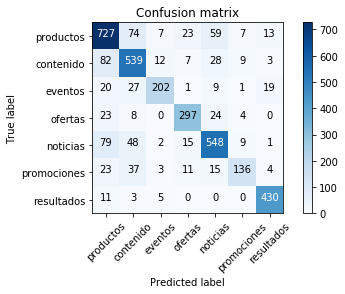

In [26]:
# Show the Confusion MAtrix of the LinealSVC Model
y_pred = optimised_svm.predict(X_test_v)
cm = plot_confusion_matrix(confusion_matrix(
    y_test, y_pred), df_modelo['Topic'].unique())

In [27]:
#Print metrics of accuracy for each topic and the summary
print(metrics.classification_report(y_test, y_pred,
                                    target_names=df_modelo['Topic'].unique()))

              precision    recall  f1-score   support

   productos       0.75      0.80      0.78       910
   contenido       0.73      0.79      0.76       680
     eventos       0.87      0.72      0.79       279
     ofertas       0.84      0.83      0.84       356
    noticias       0.80      0.78      0.79       702
 promociones       0.82      0.59      0.69       229
  resultados       0.91      0.96      0.94       449

   micro avg       0.80      0.80      0.80      3605
   macro avg       0.82      0.78      0.80      3605
weighted avg       0.80      0.80      0.80      3605

